# Deepening Embedded Drug-Target Interactions with ConPLex

The models developed for this project took an average of 30 minutes to be trained discounting for the intial embedding of inputs that could be cached. The validation and evaluation conducted similarly took over a minute to run. Therefore, we will be plotting the following from log/history files generated during training.

In [1]:
import json
import os

from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import auc, average_precision_score, precision_recall_curve, roc_curve

In [2]:
histories = {file.split(".")[0]: json.load(open(os.path.join("histories", file))) for file in os.listdir("histories")}

screening = {n: h for n, h in histories.items() if h["test_results"]["epoch"] <= 15}
testing = {n: h for n, h in histories.items() if "davis" in n}

## Initial Screening

We conducted an early screening of a variety of model types in 15 epochs, instead of the usual 50 epochs mentioned in the research paper. All of training and validation was conducted using the Davis dataset. Contrastive learning was disabled accounting for the lack of decoys.

#### Models
* Baseline (single perceptron)
* CNN
* Cross Attention
* Duo Layer (Perceptron)
* Large (Duo) Layer (Perceptron)
* Quintuple (Layer Perceptron)
* Residual
* Small (Duo) Layer (Perceptron)
* Triple Layer (Perceptron)

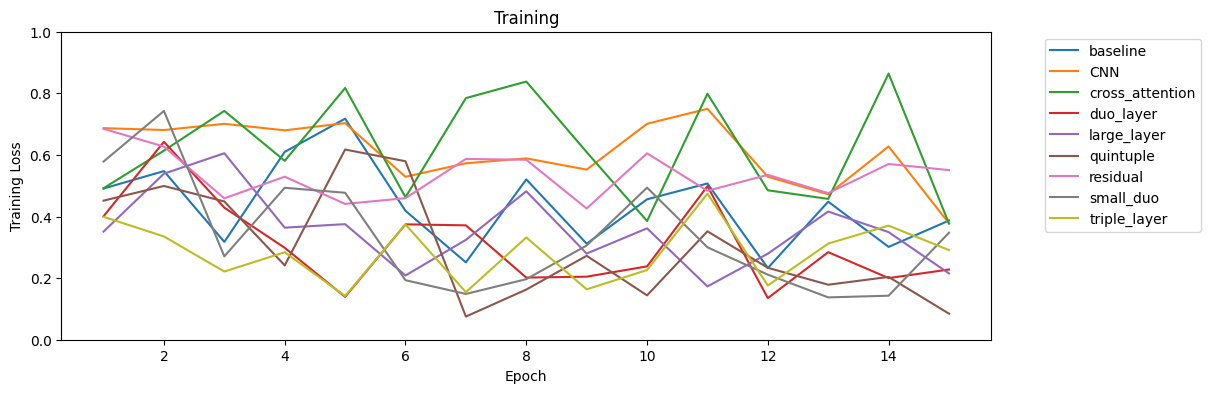

In [3]:
plt.figure(figsize=(12, 4))

for name, model in screening.items():
    plt.plot(range(1, 16), model["train_loss"], label=name)

plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1))

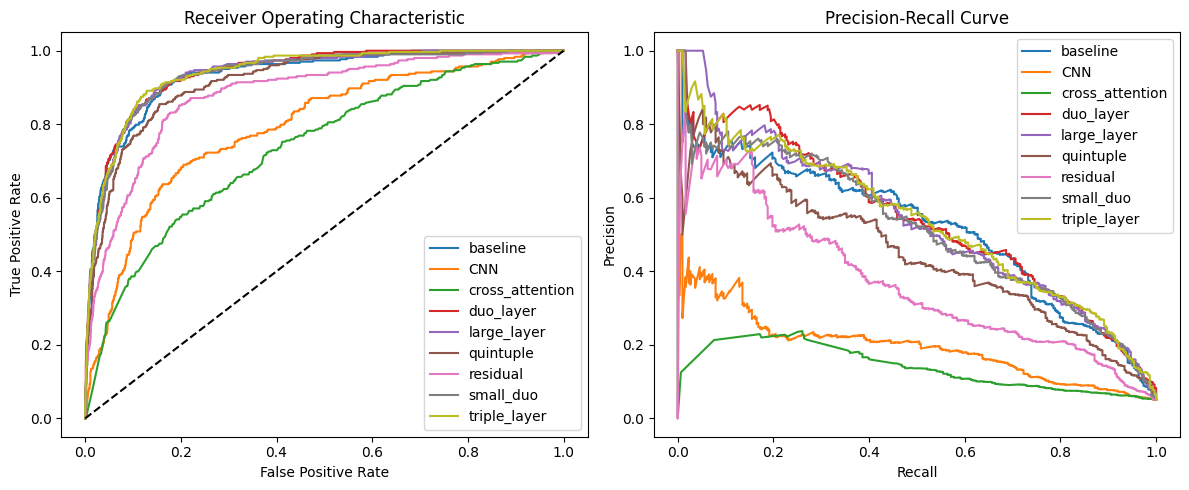

In [4]:
_, (roc, prc) = plt.subplots(1, 2, figsize=(12, 5))

for name, history in screening.items():
    evaluation = history["evaluation"]
    labels = evaluation["labels"]
    preds = evaluation["preds"]
    
    fpr, tpr, _ = roc_curve(labels, preds)
    precision, recall, _ = precision_recall_curve(labels, preds)
    
    history["Screening AUROC"] = auc(fpr, tpr)
    history["Screening AUPR"] = average_precision_score(labels, preds)
    
    roc.plot(fpr, tpr, label=name)
    prc.plot(recall, precision, label=name)

roc.plot([0, 1], [0, 1], "k--")
roc.set_title("Receiver Operating Characteristic")
roc.set_xlabel("False Positive Rate")
roc.set_ylabel("True Positive Rate")
roc.legend()

prc.set_title("Precision-Recall Curve")
prc.set_xlabel("Recall")
prc.set_ylabel("Precision")
prc.legend()

plt.tight_layout()

In [5]:
pd.DataFrame(screening).T[["Screening AUROC", "Screening AUPR"]].sort_values(by="Screening AUPR", ascending=False) # type: ignore

,Screening AUROC,Screening AUPR
duo_layer,0.939993,0.5408
large_layer,0.937022,0.535805
triple_layer,0.93994,0.535398
small_duo,0.934399,0.517335
baseline,0.933034,0.516749
quintuple,0.916646,0.445599
residual,0.880454,0.368105
CNN,0.791915,0.19842
cross_attention,0.735064,0.142155


## Testing

A limitation of the paper was the noted small AUPR value for the Davis dataset. Hence, we've decided to focus our attention to improving on the recall.

After screening a variety of model architectures, we found that a simple MLP performed best. We even explored a few variations of this MLP to tune the size of its hidden layer and the amount of hidden layers. The best performing model had a single hidden layer with the dimention as the latent space.

We conducted some further testing by training the baseline model and our new model till an automatic stopping epoch (when the validation metrics cease improving past a "patiece" threshold).

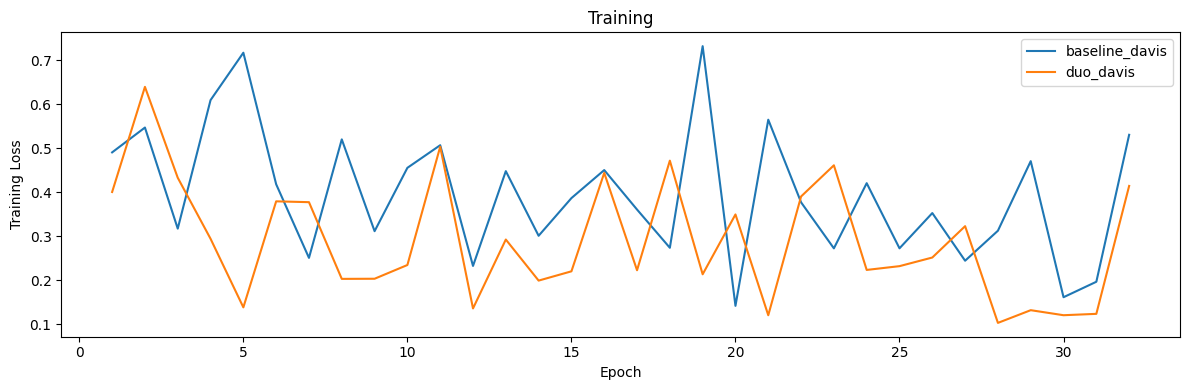

In [6]:
plt.figure(figsize=(12, 4))

for name, model in testing.items():
    plt.plot(range(1, 33), model["train_loss"][:32], label=name)

plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.tight_layout()

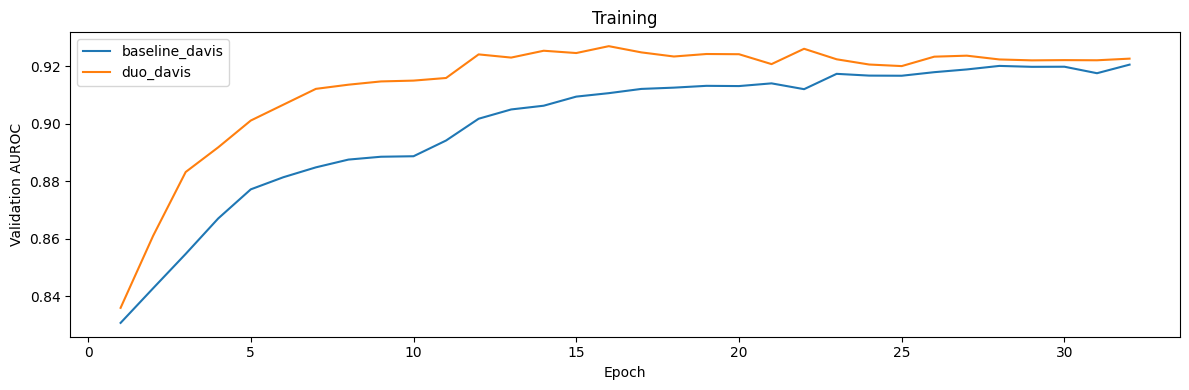

In [7]:
plt.figure(figsize=(12, 4))

for name, model in testing.items():
    plt.plot(range(1, 33), model["val_auroc"][:32], label=name)

plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("Validation AUROC")
plt.legend()
plt.tight_layout()

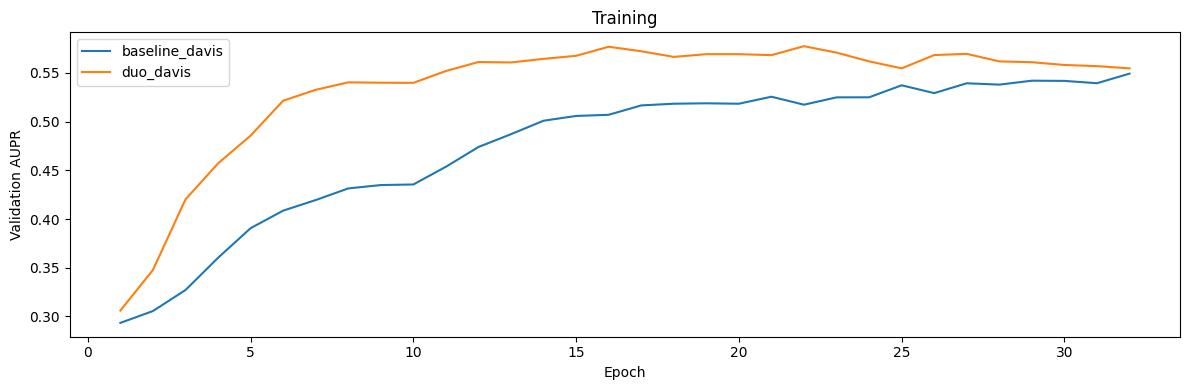

In [8]:
plt.figure(figsize=(12, 4))

for name, model in testing.items():
    plt.plot(range(1, 33), model["val_aupr"][:32], label=name)

plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("Validation AUPR")
plt.legend()
plt.tight_layout()

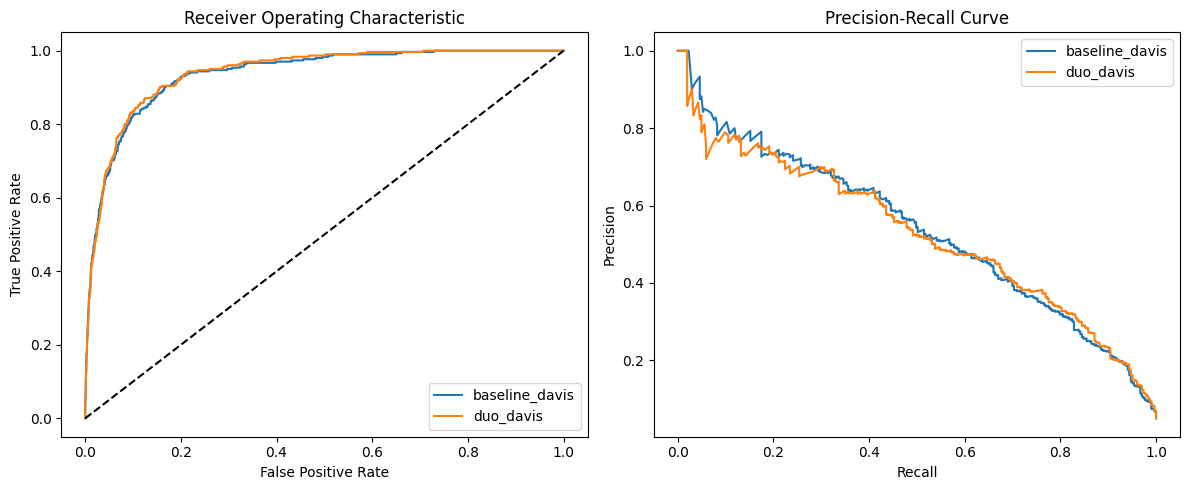

In [9]:
_, (roc, prc) = plt.subplots(1, 2, figsize=(12, 5))

for name, history in testing.items():
    evaluation = history["evaluation"]
    labels = evaluation["labels"]
    preds = evaluation["preds"]
    
    fpr, tpr, _ = roc_curve(labels, preds)
    precision, recall, _ = precision_recall_curve(labels, preds)
    
    history["Testing AUROC"] = auc(fpr, tpr)
    history["Testing AUPR"] = average_precision_score(labels, preds)
    
    roc.plot(fpr, tpr, label=name)
    prc.plot(recall, precision, label=name)

roc.plot([0, 1], [0, 1], "k--")
roc.set_title("Receiver Operating Characteristic")
roc.set_xlabel("False Positive Rate")
roc.set_ylabel("True Positive Rate")
roc.legend()

prc.set_title("Precision-Recall Curve")
prc.set_xlabel("Recall")
prc.set_ylabel("Precision")
prc.legend()

plt.tight_layout()

In [10]:
pd.DataFrame(testing).T[["Testing AUROC", "Testing AUPR"]].sort_values(by="Testing AUPR", ascending=False) # type: ignore

,Testing AUROC,Testing AUPR
baseline_davis,0.935862,0.536214
duo_davis,0.939739,0.52909
